<a href="https://colab.research.google.com/github/adrianmoagne/machine-learning-study/blob/main/makemore_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-10-21 13:29:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-10-21 13:29:41 (5.53 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [15]:
words = open('names.txt', 'r').read().splitlines()

In [16]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [17]:
import random
random.seed(42)
random.shuffle(words)

In [18]:
block_size = 3

def build_dataset(words):

  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [20]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out


  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, momentum=0.1, eps=1e-5):
    self.training = True
    self.eps = eps
    self.momentum = momentum
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)

    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self. out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum)  * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum)  * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []




In [21]:
torch.manual_seed(42);

In [22]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # Last layer make less confident


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


12097


In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) #concatenate the vectors
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


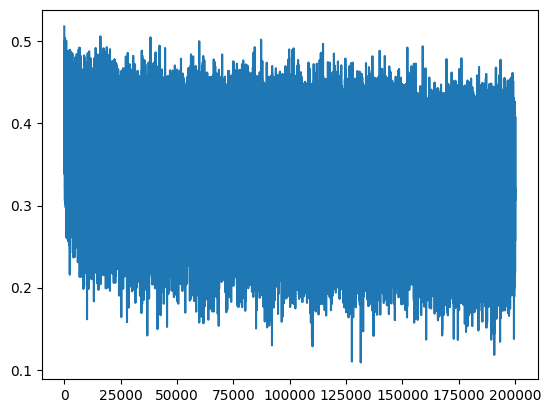

In [25]:
plt.plot(lossi) # loss function looks very crazy and that's because 32 batch elements are too few and so you can get very lucky or unlucky
# in any one of these batches and it creates a very thick loss function

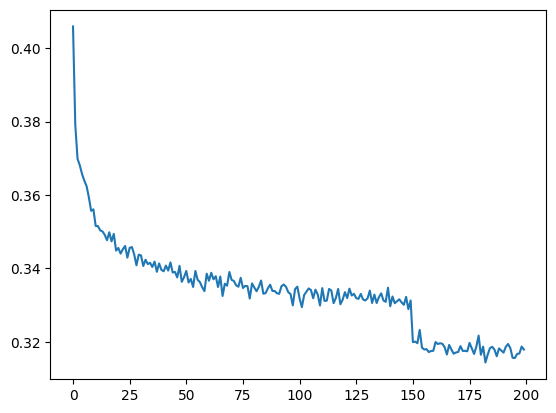

In [26]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
for layer in layers:
  layer.training = False

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


In [ ]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

tana.
milynn.
ilo.
carmelyson.
jaell.
corrose.
abdul.
lyn.
tyla.
nevaah.
rixy.
coro.
jastania.
aria.
braemanuel.
zaidleah.
arae.
amon.
goblya.
assiauri.
